## Data reading and Data Insights

**Concretizing the good things done during the day by writing them down participant: feeemr5d, 32 days participation**

*Dataset:*  Concretizing the good things done during the day by writing them down (A) vs Not concretizing
 the good things done during the day by writing them down (B) (continue daily routine normally) study


#### Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan


In [23]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__concretizing_the_good_things_-_feeemr5d_2025-06-10 20_45_23.052//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__concretizing_the_good_things_-_feeemr5d_2025-06-10 20_45_23.052//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: feeemr5d
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [24]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '17369199-4be8-4a38-b702-4f7f083ef821'


#### Participation of the study

In [25]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  17369199-4be8-4a38-b702-4f7f083ef821                  29


During the 32-day study period, there were 3 days without any participation.

#### Missing Values

In [26]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 17369199-4be8-4a38-b702-4f7f083ef821 ---

  Outcome:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 29
    Missed days count:    3
    Missed dates:
       2025-05-14
       2025-05-30
       2025-06-10

  Mediators:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-05-14
       2025-05-27
       2025-05-30
       2025-06-10


#### Remove Participants Who Joined Outside the Study

In [27]:
#df_mea = df_mea[df_mea['participant_id'] != 'ae098342-296b-4dca-83c0-76b2f3507008']
#df_mea.shape[0]

#### Data Preperation

In [28]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(10)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-06-09 19:12:46.742106+00:00,Mediators,17369199-4be8-4a38-b702-4f7f083ef821,31,Avoid writing today's wins!,NaN,NaN,NaN,NaN,8.0,6.0
1,2025-06-09 19:12:40.878367+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,31,Avoid writing today's wins!,8.0,7.0,1.0,7.0,NaN,NaN
2,2025-06-08 19:01:08.673273+00:00,Mediators,17369199-4be8-4a38-b702-4f7f083ef821,30,Avoid writing today's wins!,NaN,NaN,NaN,NaN,9.0,6.0
3,2025-06-08 19:01:02.497014+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,30,Avoid writing today's wins!,8.0,6.0,1.0,7.0,NaN,NaN
4,2025-06-07 21:45:28.542567+00:00,Mediators,17369199-4be8-4a38-b702-4f7f083ef821,29,Avoid writing today's wins!,NaN,NaN,NaN,NaN,8.0,4.0
5,2025-06-07 21:45:23.861952+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,29,Avoid writing today's wins!,7.0,8.0,1.0,6.0,NaN,NaN
6,2025-06-06 19:46:28.951252+00:00,Mediators,17369199-4be8-4a38-b702-4f7f083ef821,28,Avoid writing today's wins!,NaN,NaN,NaN,NaN,8.0,6.0
7,2025-06-06 19:46:21.642930+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,28,Avoid writing today's wins!,7.0,7.0,1.0,7.0,NaN,NaN
8,2025-06-05 20:06:33.390254+00:00,Mediators,17369199-4be8-4a38-b702-4f7f083ef821,27,Writing down the day's positives!,NaN,NaN,NaN,NaN,9.0,4.0
9,2025-06-05 20:06:23.597651+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,27,Writing down the day's positives!,7.0,8.0,7.0,1.0,NaN,NaN


In [29]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [30]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [31]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
58,2025-05-10 20:02:15.806462+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,1,Writing down the day's positives!,8.0,7.0,6.0,1.0,NaN,NaN
56,2025-05-11 19:26:00.058247+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,2,Writing down the day's positives!,7.0,5.0,6.0,1.0,NaN,NaN
54,2025-05-12 19:26:17.408141+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,3,Writing down the day's positives!,4.0,7.0,6.0,1.0,NaN,NaN
52,2025-05-13 20:17:12.442631+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,4,Avoid writing today's wins!,8.0,4.0,1.0,5.0,NaN,NaN
50,2025-05-15 20:12:37.906121+00:00,Outcome,17369199-4be8-4a38-b702-4f7f083ef821,6,Avoid writing today's wins!,5.0,8.0,1.0,6.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)    

#### Data Shape

In [32]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 29
Columns: 11


#### Data Types of columns

In [33]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [34]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:

        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 17369199-4be8-4a38-b702-4f7f083ef821 ---

  Outcome:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 29
    Missed days count:    3
    Missed dates:
       2025-05-14
       2025-05-30
       2025-06-10

  Mediators:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-05-14
       2025-05-27
       2025-05-30
       2025-06-10

  survey1_question1_response:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 29
    Missed days count:    3
    Missed dates:
       2025-05-14
       2025-05-30
       2025-06-10

  survey1_question2_response:
    Start date:           2025-05-10
    End of expected 16d:  2025-06-10
    Expected days count:  32
    Completed days count: 29
    Miss

#### Missing Values for Confirmations between 08.00 - 21.00

In [35]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

Missing participation days and their corresponding task names:
          date intervention_task_name
23  2025-06-01                    NaN


#### Summary Statistics

In [36]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             29.000000                   29.000000   
mean              16.241379                    6.482759   
std                9.136486                    1.326130   
min                1.000000                    4.000000   
25%                9.000000                    6.000000   
50%               16.000000                    7.000000   
75%               24.000000                    7.000000   
max               31.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   29.000000                   29.000000   
mean                     6.586207                    3.655172   
std                      0.982607                    2.844492   
min                      4.000000                    1.000000   
25%                      6.000000                    1.000000   
50%                      6.000000               

In [37]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 58 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            29 non-null     datetime64[ns, UTC]
 1   measurement_name            29 non-null     object             
 2   participant_id              29 non-null     object             
 3   current_day_of_study        29 non-null     int64              
 4   current_intervention_name   29 non-null     object             
 5   survey1_question1_response  29 non-null     float64            
 6   survey1_question2_response  29 non-null     float64            
 7   survey1_question3_response  29 non-null     float64            
 8   survey1_question4_response  29 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

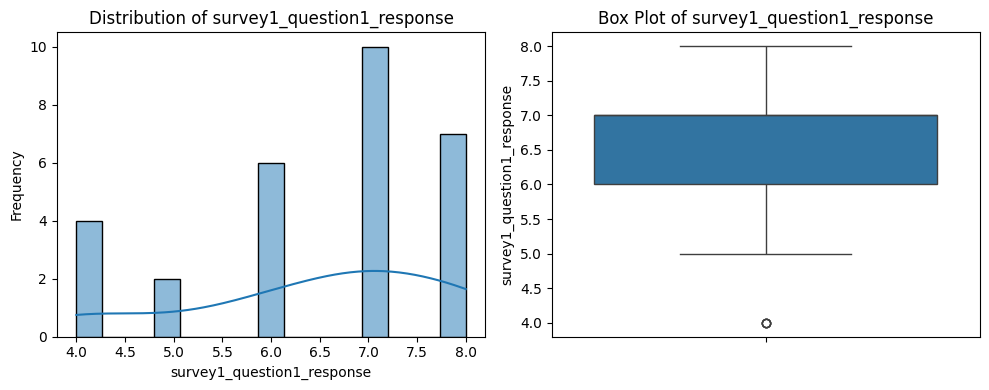

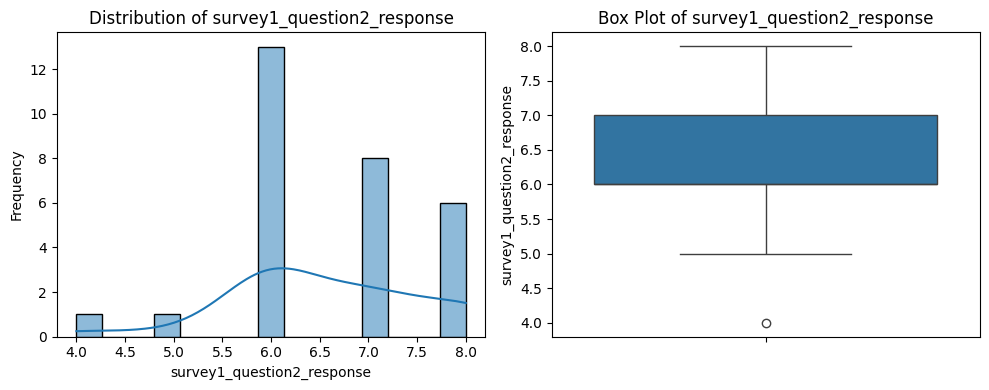

In [38]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

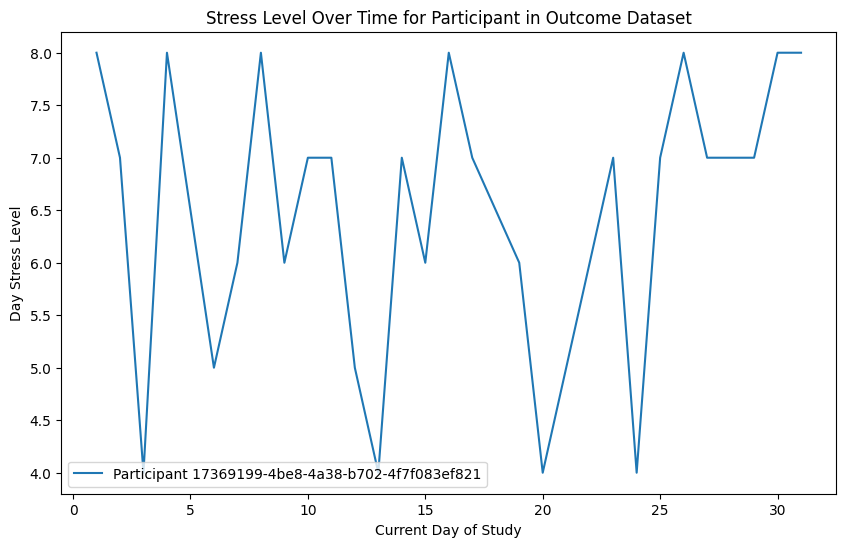

In [39]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6))

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Participant in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

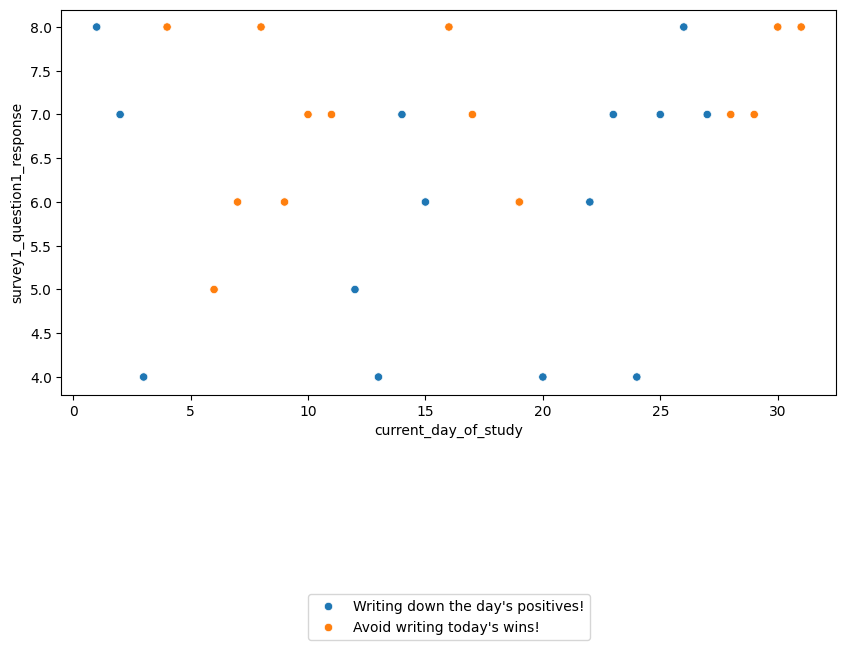

In [40]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

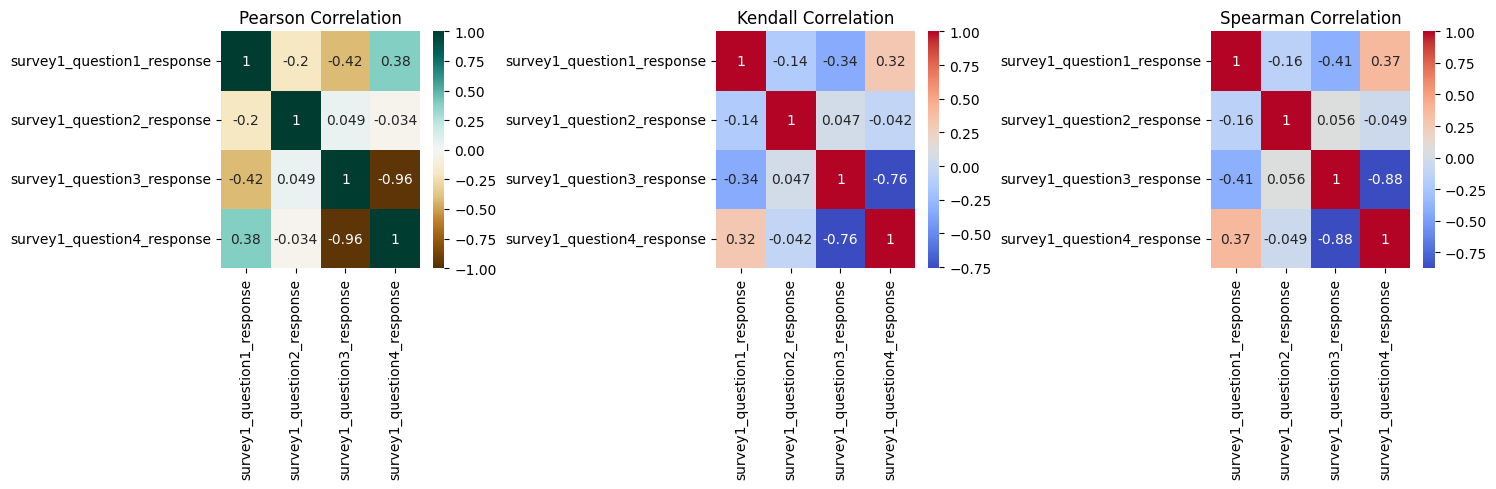

In [41]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Intervention - Concretizing the good things vs Not concretizing the good things

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [42]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Writing down the day's positives!",
        "Avoid writing today's wins!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Writing down the day's positives!",
    'survey1_question1_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing today's wins!",
    'survey1_question1_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Concretizing good things:           n = 14, std = 1.52, mean = 6.00
Not concretizing good things:       n = 15, std = 0.96, mean = 6.93



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [43]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Writing down the day's positives!",
        "Avoid writing today's wins!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Writing down the day's positives!",
    'survey1_question2_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing today's wins!",
    'survey1_question2_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Concretizing good things:           n = 14, std = 0.84, mean = 6.64
Not concretizing good things:       n = 15, std = 1.13, mean = 6.53



#### Examination of Outcomes: Mean Stress-Relief Score for Concretizing good things (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much  to concretizing good things alleviated participants’ stress on days they performed.

In [44]:
df_mea.survey1_question3_text[0]

'How much did this method (listening to music) help you today? <b>(1 = Not helpful at all to 10 = Very helpful) <i>(Answer ONLY if you have listened to music!)</i></b>'

In [45]:
# 'How much did this method (Concretizing good things) help you today? <b>(1 = Not helpful at all to 10 = Very helpful) <i>(Answer ONLY if you have wrote down days positive!)</i></b>'

mean_q3_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Writing down the day's positives!",
    'survey1_question3_response'
].mean()
mean_q3_concretizing.item()


6.5

**Mean Self-Improvement Score for Concretizing Good Things (Q3): 6.5:**
On days when the participant wrote down the day’s positives, she rated Question 3—“How much did this method (Concretizing good things) help you today?”—an average of **6.5 out of 10**, indicating that writing down positives provided a notable benefit.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Concretizing Good Things (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not note positive things they have done during the day.

In [46]:
df_mea.survey1_question4_text[0]

'Did you have difficulty without the method? <b>(1 = No difficulty to 5 = Significant difficulty) <i>(Answer ONLY if you have NOT listened to music!)</i></b>'

In [47]:
# 'Did you have difficulty without the method? <b>(1 = No difficulty to 5 = Significant difficulty) <i>(Answer ONLY if you have NOT wrote down.)</i></b>'

mean_q4_avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing today's wins!",
    'survey1_question4_response'
].mean()
mean_q4_avoid_concretizing.item()


6.533333333333333

**Mean Stress-Management Difficulty Score Without Concretizing Good Things (Q4): 6.53:**
On days when the participant did not write down the day’s positives, she rated Question 4—“Did you have difficulty without the method?”—an average of **6.53 out of 10**, indicating that skipping this practice posed a notable challenge in managing her stress.


### Estimating treatment effect using Linear Regression with Autoregressive errors

In [48]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Writing down the day's positives!", "Avoid writing today's wins!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Writing down the day's positives!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.128
Model:                                    OLS   Adj. R-squared:                  0.096
Method:                         Least Squares   F-statistic:                     3.967
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):             0.0566
Time:                                05:05:55   Log-Likelihood:                -46.838
No. Observations:                          29   AIC:                             97.68
Df Residuals:                              27   BIC:                             100.4
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [49]:
# GLSAR Regression with AR(1) errors (Feasible GLS)
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.176
Model:                                  GLSAR   Adj. R-squared:                  0.145
Method:                         Least Squares   F-statistic:                     5.562
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):             0.0262
Time:                                05:05:55   Log-Likelihood:                -44.233
No. Observations:                          28   AIC:                             92.47
Df Residuals:                              26   BIC:                             95.13
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators

Model: Neither fac1 nor fac2(intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 149 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.690  0.458    -1.510      0.239      0.017    0.016     712.0   
rho       0.055  0.208    -0.341      0.445      0.007    0.011     780.0   
sigma     1.280  0.170     0.972      1.585      0.007    0.005     574.0   

          ess_tail  r_hat  
beta_int     519.0   1.00  
rho          636.0   1.01  
sigma        417.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 66.60%
P(beta_int ≤ –0.5) = 66.60%
P(–0.5 < beta_int < 0) = 28.20%
P(beta_int ≥ 0) = 5.20%


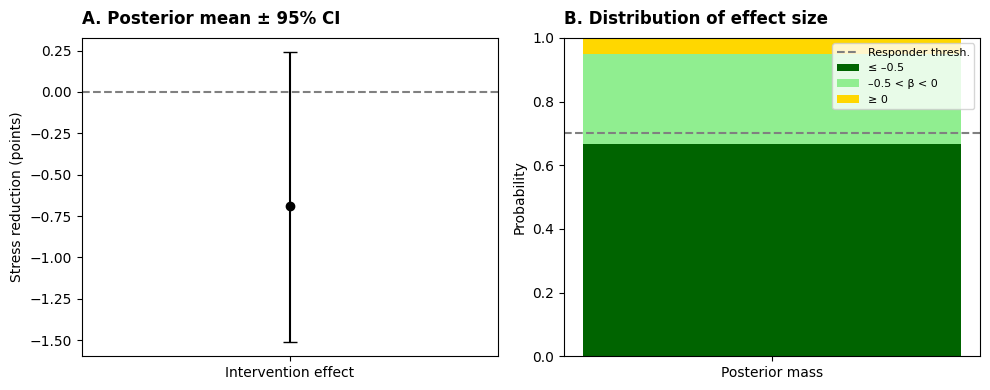

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 682 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.618  0.296    -1.151      0.014      0.011    0.013     727.0   
rho       0.018  0.202    -0.390      0.425      0.009    0.008     496.0   
sigma     0.772  0.112     0.588      1.009      0.005    0.006     490.0   
beta_f1   0.787  0.113     0.601      1.049      0.007    0.005     246.0   

          ess_tail  r_hat  
beta_int     462.0    1.0  
rho          408.0    1.0  
sigma        575.0    1.0  
beta_f1      408.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 68.20%
P(beta_int ≤ –0.5) = 68.20%
P(–0.5 < beta_int < 0) = 29.70%
P(beta_int ≥ 0) = 2.10%


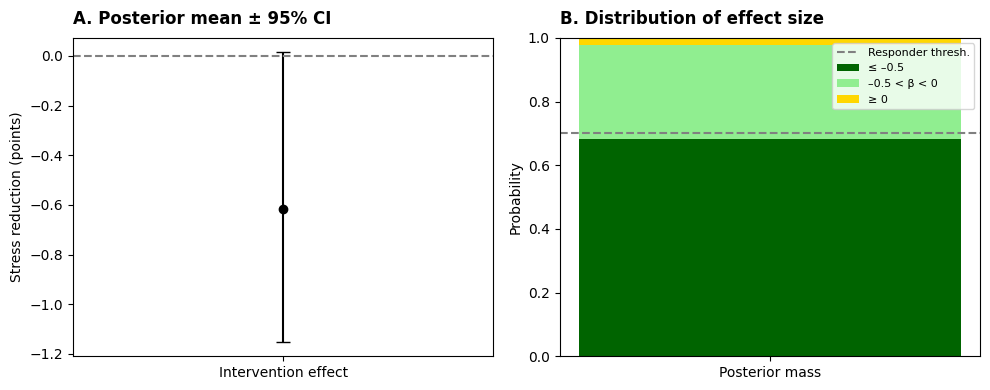

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 520 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.401  0.305    -0.951      0.284      0.011    0.010     729.0   
rho       0.078  0.194    -0.314      0.429      0.009    0.007     482.0   
sigma     0.873  0.119     0.673      1.125      0.004    0.004     751.0   
beta_f2   0.865  0.159     0.547      1.191      0.007    0.006     472.0   

          ess_tail  r_hat  
beta_int     560.0   1.00  
rho          480.0   1.00  
sigma        519.0   1.00  
beta_f2      530.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 35.40%
P(beta_int ≤ –0.5) = 35.40%
P(–0.5 < beta_int < 0) = 56.10%
P(beta_int ≥ 0) = 8.50%


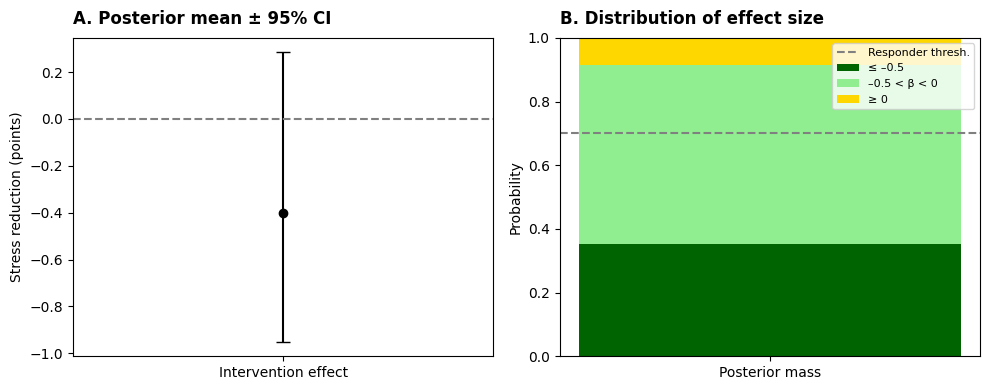

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 684 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.454  0.238    -0.954      0.004      0.010    0.008     634.0   
rho       0.120  0.193    -0.264      0.482      0.009    0.006     497.0   
sigma     0.646  0.099     0.462      0.826      0.005    0.004     391.0   
beta_f1   0.554  0.118     0.298      0.769      0.006    0.005     465.0   
beta_f2   0.482  0.147     0.191      0.763      0.007    0.007     481.0   

          ess_tail  r_hat  
beta_int     565.0    1.0  
rho          580.0    1.0  
sigma        373.0    1.0  
beta_f1      385.0    1.0  
beta_f2      377.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 42.20%
P(beta_int ≤ –0.5) = 42.20%
P(–0.5 < beta_int < 0) = 54.50%
P(beta_int ≥ 0) = 3.30%


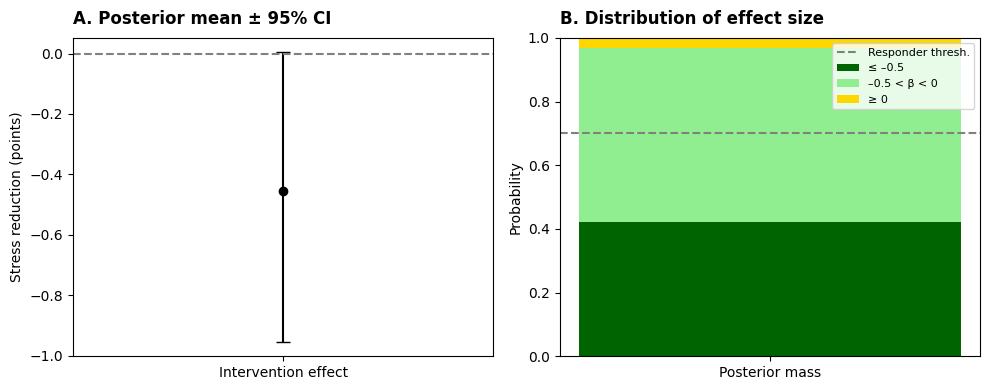

In [50]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Writing down the day's positives!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2(intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 146 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.834  0.499    -1.761      0.182      0.023    0.020     561.0   
rho       0.073  0.215    -0.349      0.508      0.012    0.012     368.0   
sigma     1.305  0.180     0.974      1.655      0.006    0.006     787.0   

          ess_tail  r_hat  
beta_int     371.0    1.0  
rho          254.0    1.0  
sigma        665.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 75.20%
P(beta_int ≤ –0.5) = 75.20%
P(–0.5 < beta_int < 0) = 20.80%
P(beta_int ≥ 0) = 4.00%


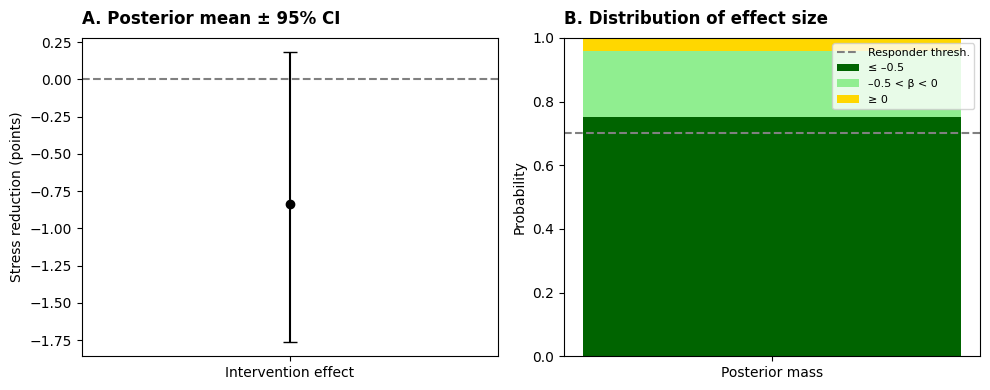


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 575 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.634  0.282    -1.157     -0.041      0.011    0.012     650.0   
rho       0.026  0.213    -0.405      0.420      0.009    0.009     640.0   
sigma     0.772  0.106     0.596      1.000      0.004    0.003     660.0   
beta_f1   0.811  0.105     0.599      0.995      0.004    0.004     564.0   

          ess_tail  r_hat  
beta_int     551.0   1.00  
rho          555.0   1.00  
sigma        624.0   1.00  
beta_f1      636.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 69.90%
P(beta_int ≤ –0.5) = 69.90%
P(–0.5 < beta_int < 0) = 28.90%
P(beta_int ≥ 0) = 1.20%


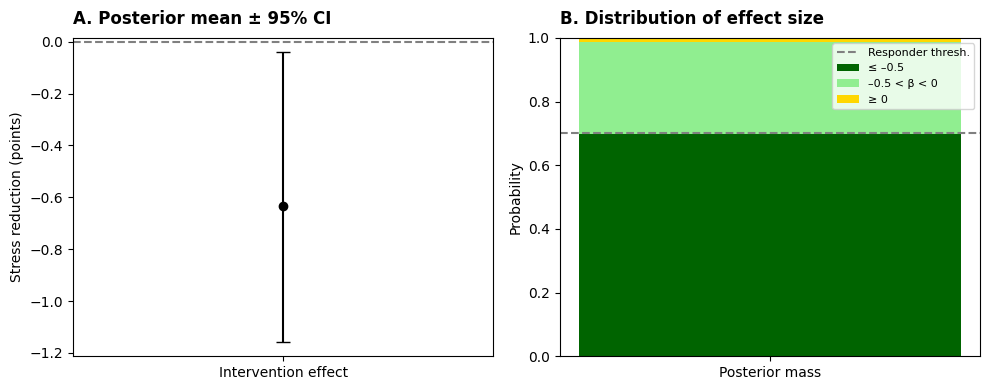


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 419 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.362  0.336    -1.122      0.200      0.014    0.012     626.0   
rho       0.081  0.212    -0.337      0.461      0.009    0.009     515.0   
sigma     0.885  0.122     0.674      1.131      0.005    0.005     542.0   
beta_f2   0.914  0.151     0.636      1.212      0.008    0.006     388.0   

          ess_tail  r_hat  
beta_int     472.0    1.0  
rho          390.0    1.0  
sigma        602.0    1.0  
beta_f2      460.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 33.20%
P(beta_int ≤ –0.5) = 33.20%
P(–0.5 < beta_int < 0) = 53.80%
P(beta_int ≥ 0) = 13.00%


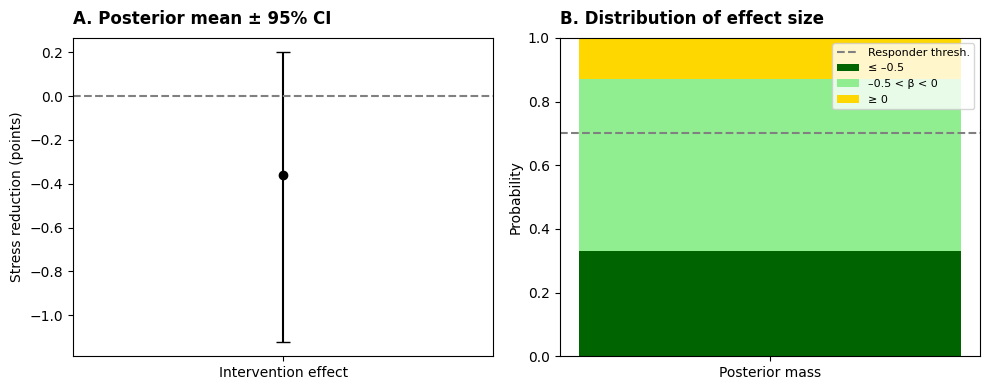


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 733 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.434  0.253    -0.882      0.087      0.011    0.011     552.0   
rho       0.119  0.225    -0.261      0.576      0.012    0.019     407.0   
sigma     0.656  0.097     0.486      0.845      0.005    0.004     521.0   
beta_f1   0.564  0.115     0.326      0.779      0.006    0.004     375.0   
beta_f2   0.489  0.140     0.204      0.766      0.008    0.006     299.0   

          ess_tail  r_hat  
beta_int     292.0   1.00  
rho          317.0   1.00  
sigma        679.0   1.01  
beta_f1      424.0   1.00  
beta_f2      345.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 39.80%
P(beta_int ≤ –0.5) = 39.80%
P(–0.5 < beta_int < 0) = 55.90%
P(beta_int ≥ 0) = 4.30%


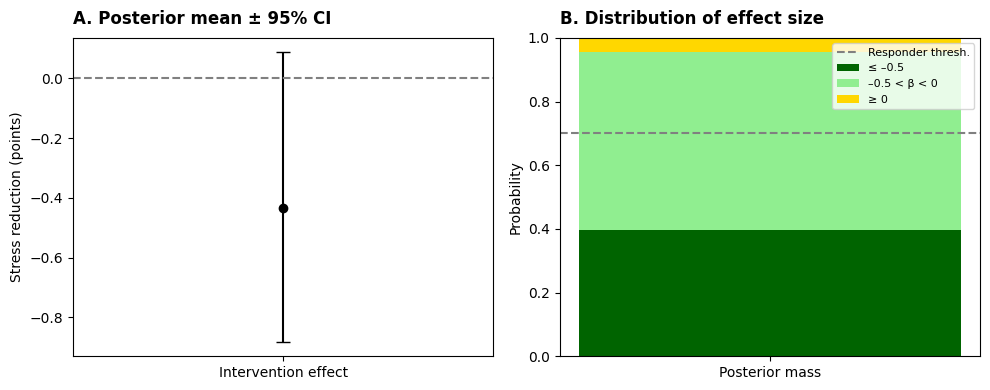

In [51]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Writing down the day's positives!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 248 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.713  0.395    -1.483      0.082      0.017    0.012     573.0   
rho      -0.016  0.228    -0.470      0.422      0.008    0.007     840.0   
sigma     1.263  0.168     0.959      1.592      0.005    0.005    1101.0   

          ess_tail  r_hat  
beta_int     597.0   1.00  
rho          714.0   1.01  
sigma        770.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 70.90%
P(beta_int ≤ –0.5) = 70.90%
P(–0.5 < beta_int < 0) = 25.60%
P(beta_int ≥ 0) = 3.50%


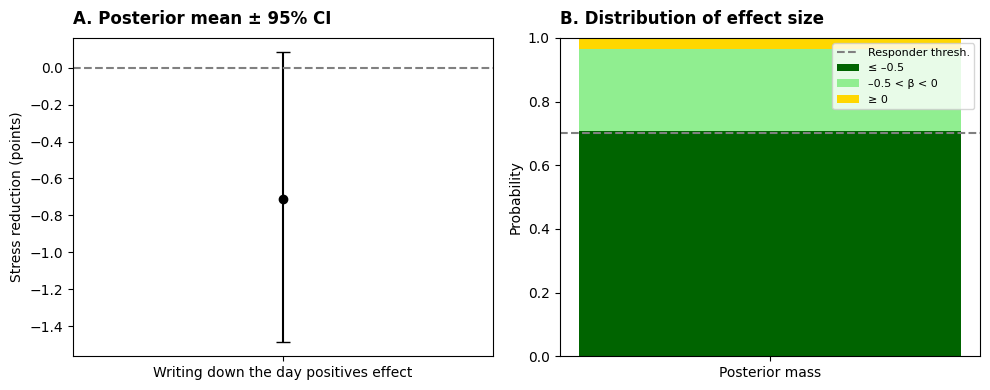


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 913 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.628  0.266    -1.118     -0.060      0.010    0.009     663.0   
rho      -0.054  0.249    -0.572      0.439      0.013    0.009     369.0   
sigma     0.756  0.102     0.569      0.962      0.005    0.004     495.0   
beta_f1   0.783  0.115     0.548      1.001      0.007    0.005     261.0   

          ess_tail  r_hat  
beta_int     493.0   1.01  
rho          420.0   1.01  
sigma        550.0   1.01  
beta_f1      319.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 69.60%
P(beta_int ≤ –0.5) = 69.60%
P(–0.5 < beta_int < 0) = 29.40%
P(beta_int ≥ 0) = 1.00%


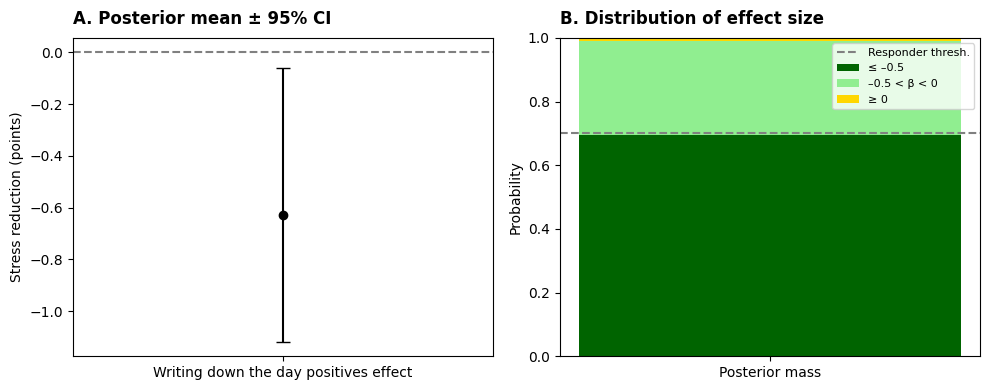


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 422 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.355  0.308    -0.866      0.357      0.013    0.011     558.0   
rho       0.023  0.224    -0.424      0.421      0.009    0.007     570.0   
sigma     0.875  0.131     0.660      1.141      0.006    0.006     465.0   
beta_f2   0.872  0.155     0.606      1.182      0.010    0.006     248.0   

          ess_tail  r_hat  
beta_int     418.0   1.01  
rho          630.0   1.00  
sigma        487.0   1.00  
beta_f2      352.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 31.20%
P(beta_int ≤ –0.5) = 31.20%
P(–0.5 < beta_int < 0) = 55.70%
P(beta_int ≥ 0) = 13.10%


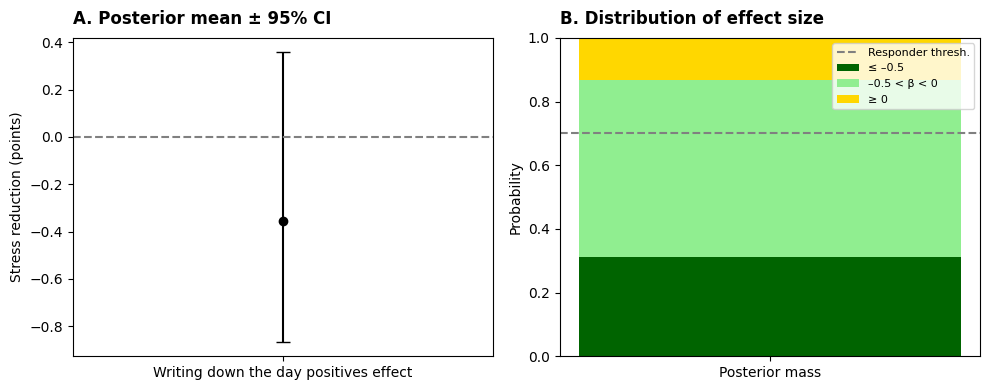


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 660 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.443  0.229    -0.893      0.042      0.009    0.007     664.0   
rho      -0.005  0.245    -0.489      0.454      0.010    0.008     575.0   
sigma     0.649  0.095     0.483      0.851      0.005    0.003     447.0   
beta_f1   0.554  0.124     0.334      0.806      0.006    0.005     407.0   
beta_f2   0.463  0.143     0.154      0.714      0.006    0.005     583.0   

          ess_tail  r_hat  
beta_int     556.0   1.00  
rho          472.0   1.00  
sigma        558.0   1.00  
beta_f1      504.0   1.01  
beta_f2      439.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 40.40%
P(beta_int ≤ –0.5) = 40.40%
P(–0.5 < beta_int < 0) = 56.10%
P(beta_int ≥ 0) = 3.50%


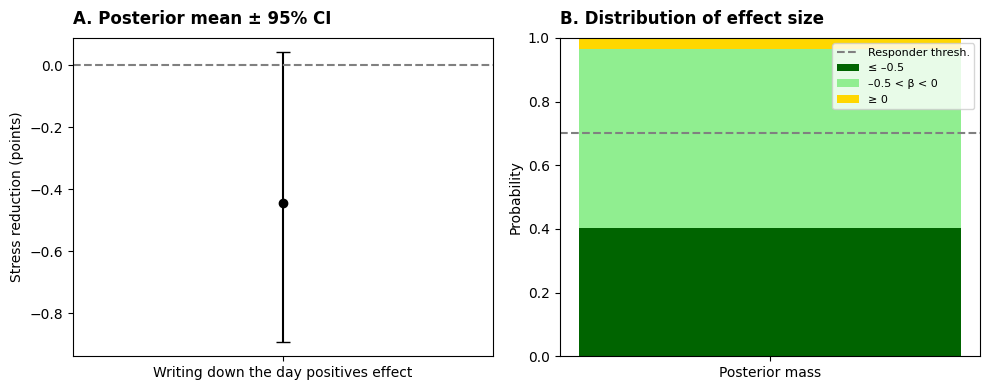

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int -0.443  0.229    -0.893      0.042      0.009    0.007     664.0   
 rho      -0.005  0.245    -0.489      0.454      0.010    0.008     575.0   
 sigma     0.649  0.095     0.483      0.851      0.005    0.003     447.0   
 beta_f1   0.554  0.124     0.334      0.806      0.006    0.005     407.0   
 beta_f2   0.463  0.143     0.154      0.714      0.006    0.005     583.0   
 
           ess_tail  r_hat  
 beta_int     556.0   1.00  
 rho          472.0   1.00  
 sigma        558.0   1.00  
 beta_f1      504.0   1.01  
 beta_f2      439.0   1.01  )

In [52]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Writing down the day's positives!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Writing down the day positives effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to Concretizing the Good Thins and Mediators - Mean Imputation Method

In [53]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 32)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_2060\1570007407.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_2060\1570007407.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [54]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Writing down the day's positives!",
    'B': "Avoid writing today's wins!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 32))                   
    .reset_index()                           
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [55]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2(intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 86 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.886  0.421    -1.748     -0.126      0.017    0.012     649.0   
rho       0.069  0.192    -0.269      0.468      0.007    0.007     740.0   
sigma     1.235  0.156     0.921      1.529      0.006    0.006     731.0   

          ess_tail  r_hat  
beta_int     797.0    1.0  
rho          551.0    1.0  
sigma        484.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 81.60%
P(beta_int ≤ –0.5) = 81.60%
P(–0.5 < beta_int < 0) = 16.50%
P(beta_int ≥ 0) = 1.90%


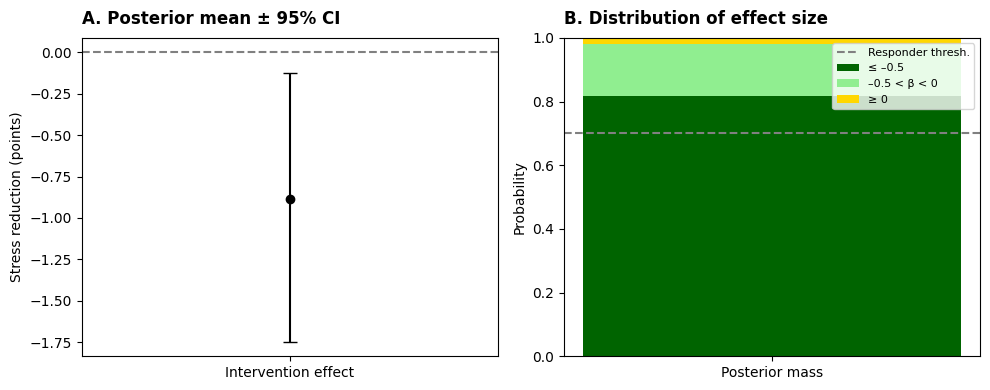

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 365 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.655  0.255    -1.187     -0.205      0.010    0.008     662.0   
rho      -0.025  0.207    -0.435      0.380      0.008    0.008     747.0   
sigma     0.730  0.101     0.538      0.924      0.004    0.004     595.0   
beta_f1   0.782  0.108     0.589      1.002      0.006    0.005     364.0   

          ess_tail  r_hat  
beta_int     597.0   1.00  
rho          434.0   1.01  
sigma        393.0   1.00  
beta_f1      345.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 71.40%
P(beta_int ≤ –0.5) = 71.40%
P(–0.5 < beta_int < 0) = 28.20%
P(beta_int ≥ 0) = 0.40%


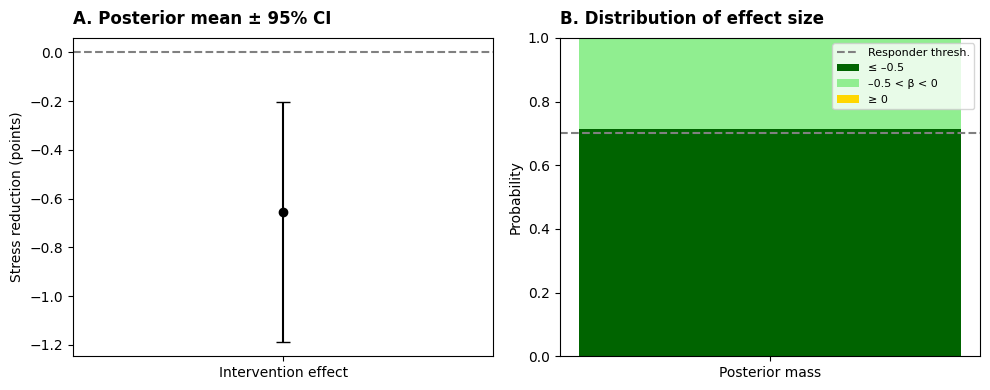

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 267 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.471  0.297    -1.072      0.068      0.012    0.009     598.0   
rho       0.014  0.198    -0.397      0.396      0.007    0.007     800.0   
sigma     0.836  0.112     0.631      1.062      0.005    0.004     429.0   
beta_f2   0.884  0.153     0.581      1.164      0.007    0.006     462.0   

          ess_tail  r_hat  
beta_int     603.0   1.01  
rho          573.0   1.00  
sigma        556.0   1.01  
beta_f2      448.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 47.00%
P(beta_int ≤ –0.5) = 47.00%
P(–0.5 < beta_int < 0) = 47.20%
P(beta_int ≥ 0) = 5.80%


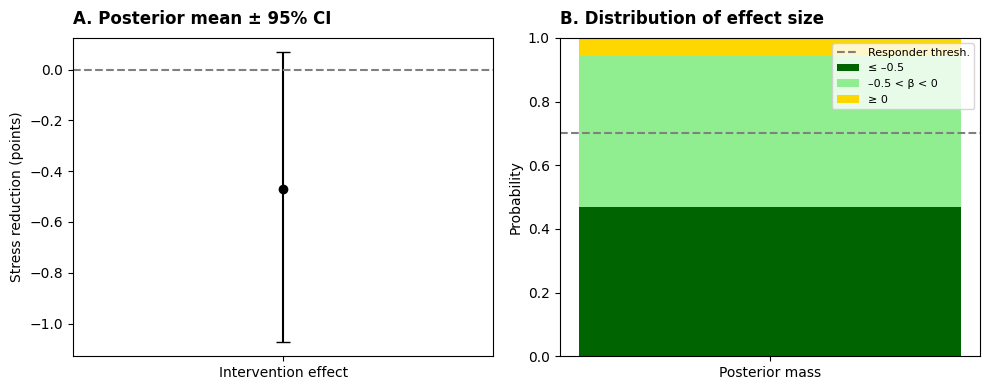

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 521 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.508  0.210    -0.911     -0.079      0.008    0.009     782.0   
rho       0.004  0.204    -0.395      0.437      0.009    0.009     539.0   
sigma     0.616  0.091     0.463      0.796      0.004    0.003     657.0   
beta_f1   0.544  0.118     0.321      0.775      0.005    0.004     472.0   
beta_f2   0.477  0.138     0.203      0.735      0.006    0.004     624.0   

          ess_tail  r_hat  
beta_int     590.0   1.00  
rho          575.0   1.01  
sigma        611.0   1.00  
beta_f1      473.0   1.00  
beta_f2      643.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 51.20%
P(beta_int ≤ –0.5) = 51.20%
P(–0.5 < beta_int < 0) = 47.70%
P(beta_int ≥ 0) = 1.10%


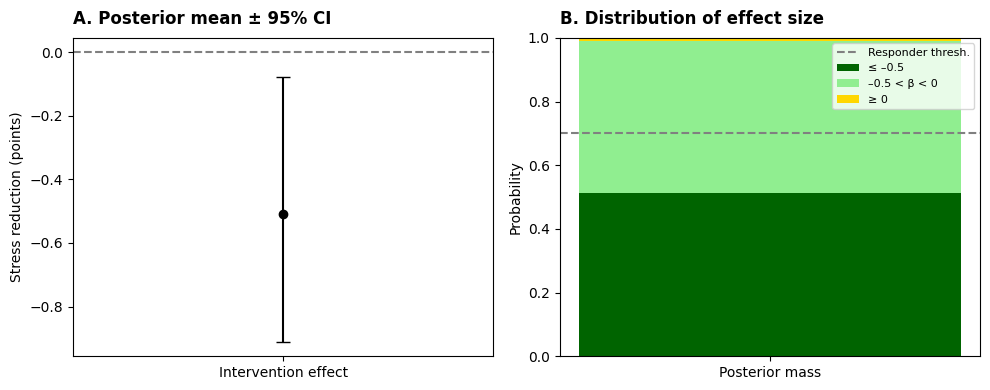

In [56]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Writing down the day's positives!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2(intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Concretizing the Good Thins and Mediators - Latent Missing Method

In [57]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Writing down the day's positives!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 298 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.881  0.489    -1.853      0.035      0.020    0.017     607.0   
rho       0.050  0.125    -0.205      0.299      0.008    0.006     265.0   
sigma     1.253  0.176     0.927      1.597      0.006    0.007     823.0   

          ess_tail  r_hat  
beta_int     430.0   1.00  
rho          338.0   1.01  
sigma        726.0   1.00  
P(beta_int ≤ –0.5) = 77.30%
P(–0.5 < beta_int < 0) = 20.00%
P(beta_int ≥ 0) = 2.70%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 576 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.618  0.292    -1.200     -0.022      0.010    0.010     814.0   
rho       0.009  0.082    -0.146      0.172      0.005    0.004     328.0   
sigma     0.752  0.104     0.583      0.955      0.004    0.004     893.0   
beta_f1   0.795  0.123     0.581      1.038      0.006    0.006     488.0   

          ess_tail  r_hat  
beta_int     720.0   1.00  
rho          376.0   1.01  
sigma        593.0   1.00  
beta_f1      453.0   1.00  
P(beta_int ≤ –0.5) = 65.90%
P(–0.5 < beta_int < 0) = 31.60%
P(beta_int ≥ 0) = 2.50%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 529 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.381  0.331    -1.059      0.272      0.013    0.013     675.0   
rho       0.016  0.081    -0.115      0.179      0.004    0.006     354.0   
sigma     0.859  0.120     0.625      1.080      0.004    0.004     851.0   
beta_f2   0.868  0.161     0.558      1.201      0.006    0.005     633.0   

          ess_tail  r_hat  
beta_int     430.0   1.00  
rho          347.0   1.00  
sigma        717.0   1.00  
beta_f2      608.0   1.01  
P(beta_int ≤ –0.5) = 35.70%
P(–0.5 < beta_int < 0) = 53.20%
P(beta_int ≥ 0) = 11.10%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 789 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.446  0.238    -0.938      0.005      0.009    0.007     674.0   
rho       0.002  0.074    -0.154      0.136      0.004    0.005     298.0   
sigma     0.633  0.088     0.488      0.812      0.003    0.003     709.0   
beta_f1   0.571  0.126     0.345      0.829      0.005    0.004     687.0   
beta_f2   0.461  0.142     0.194      0.751      0.005    0.004     841.0   

          ess_tail  r_hat  
beta_int     666.0   1.00  
rho          365.0   1.01  
sigma        812.0   1.00  
beta_f1      673.0   1.00  
beta_f2      783.0   1.00  
P(beta_int ≤ –0.5) = 41.70%
P(–0.5 < beta_int < 0) = 54.90%
P(beta_int ≥ 0) = 3.40%
